In [1]:
import os
from glob import glob
import numpy as np
import pandas as pd

In [2]:
# Orginal test set improvements
best_data = {"MSE": 1.33e-6, "MAE": 1.49e-4, "MAPE": 43.83, "MSE_pinn": 0.01}
best_PINN = {"MSE": 1.09e-6, "MAE": 1.33e-4, "MAPE": 12.97, "MSE_pinn": 1.18e-6}

percentage_improvemnts = {}
for key in best_data.keys():
    percentage_improvemnts[key] = (best_data[key] - best_PINN[key]) / best_data[key] * 100
    percentage_improvemnts[key] = np.round((best_PINN[key]-best_data[key] ) / best_data[key], 5) * 100

print(percentage_improvemnts)

{'MSE': -18.045, 'MAE': -10.738, 'MAPE': -70.408, 'MSE_pinn': -99.988}


In [3]:
# FC_1,8 + FC_9,1
best_data = {"MSE": 0.000392, "MAE": 0.003267, "MAPE": 26.433018, "MSE_pinn": np.nan}
best_PINN = {"MSE": 0.000397, "MAE": 0.003285, "MAPE": 7.373093, "MSE_pinn": np.nan}

percentage_improvemnts = {}
for key in best_data.keys():
    percentage_improvemnts[key] = (best_data[key] - best_PINN[key]) / best_data[key] * 100
    percentage_improvemnts[key] = np.round((best_PINN[key]-best_data[key] ) / best_data[key], 5) * 100

print(percentage_improvemnts)

{'MSE': 1.276, 'MAE': 0.551, 'MAPE': -72.107, 'MSE_pinn': nan}


In [4]:
experiment_paths = [os.path.realpath("./Experiment1_data"), os.path.realpath("./Experiment1"), os.path.realpath("./Experiment2")]

# load multirun yaml Omgeaconf
from omegaconf import OmegaConf

multirun_yaml_paths = []
multi_cfgs = []
sweep_cfgs = []
for experiment_path in experiment_paths:
    multirun_yaml_path = glob(f"{experiment_path}/**/multirun.yaml", recursive=True)[0]

    multi_cfg = OmegaConf.load(multirun_yaml_path)
    sweep_cfg = multi_cfg["hydra"]["sweeper"]["params"]

    multirun_yaml_paths.append(multirun_yaml_path)
    multi_cfgs.append(multirun_yaml_path)
    sweep_cfgs.append(sweep_cfg)

In [5]:
sweep_cfgs

[{'++data.data_ratio': 'choice(0.01,0.05,0.1,0.2)', 'model': 'choice(MLP_4x100,MLP_8x40)'},
 {'++data.data_ratio': 'choice(0.01,0.05,0.1,0.2)', '++data.physics.colloc_data_ratio': 'choice(0.1,0.25,0.5,1)', 'model': 'choice(MLP_4x100,MLP_8x40)'},
 {'optimizer': 'glob("opt_exp_sophia_var_*")', 'model': 'choice(MLP_4x100,MLP_8x40)'}]

In [6]:
# use regex to find instances where prepend is ++
# and store keys minus the ++ in a list
import re

sweep_keys_list = []

for sweep_cfg, experiment_path in zip(sweep_cfgs, experiment_paths):
    sweep_keys = []
    for k, v in sweep_cfg.items():
        if re.match(r"\+\+", k):
            sweep_keys.append(k[2:])
        elif re.match(r"\+", k):
            sweep_keys.append(k[2:])
        elif re.match(r"choice", v):
            if k == "optimizer":
                sweep_keys.append(f"{k}.loss_balancing.type")
            elif k == "model":
                sweep_keys.append(k)
        elif re.match(r"glob", v):
            if k == "optimizer":
              sweep_keys.append(k)
            #   checkpoint_dir_paths = glob(f"{experiment_path}*/.hydra/overrides.yaml", recursive = True)
            
    sweep_keys_list.append(sweep_keys)

sweep_keys_list

[['data.data_ratio', 'model'],
 ['data.data_ratio', 'data.physics.colloc_data_ratio', 'model'],
 ['optimizer', 'model']]

In [7]:
best_model_paths_list = []
for experiment_path in experiment_paths:
    checkpoint_dir_paths = glob(f"{experiment_path}/**/checkpoints*", recursive = True)

    best_model_paths = []
    for checkpoint_dir_path in checkpoint_dir_paths:
        subdirs = np.array(os.listdir(checkpoint_dir_path)).astype(int)
        if len(subdirs) == 0:
            best_model_path = checkpoint_dir_path+"/empty/empty"
        else:
            best_model_path = os.path.join(checkpoint_dir_path, f"{subdirs.max()}/default")
        best_model_paths.append(best_model_path)

    best_model_paths.sort()
    best_model_paths_list.append(best_model_paths)
# best_model_paths_list

In [8]:
config_paths_list = []
overrides_paths_list = []
for best_model_paths in best_model_paths_list:
    config_paths = [best_model_path.split("/")[:-3]+[".hydra/config.yaml"] for best_model_path in best_model_paths]
    config_paths = ["/".join(config_path) for config_path in config_paths]
    config_paths_list.append(config_paths)
    overrides_paths = [best_model_path.split("/")[:-3]+[".hydra/overrides.yaml"] for best_model_path in best_model_paths]
    overrides_paths = ["/".join(overrides_path) for overrides_path in overrides_paths]
    overrides_paths_list.append(overrides_paths)
# print(len(config_paths_list), config_paths_list)
# print(len(overrides_paths_list), overrides_paths_list)

In [9]:
from benedict import benedict

sweep_values_df_list = []


for config_paths, overrides_paths, sweep_keys in zip(config_paths_list, overrides_paths_list, sweep_keys_list):
    sweep_values_df = pd.DataFrame(columns=sweep_keys)
    for i, (config_path, overrides_path) in enumerate(zip(config_paths, overrides_paths)):
        cfg = OmegaConf.load(config_path)
        ovr = benedict.from_yaml(overrides_path)
        ovr = ovr["values"]
        for val in ovr:
            splitted_ovr = val.split("=")
            if "." not in splitted_ovr[0]:
                model_values = []
                cfg[splitted_ovr[0]] = splitted_ovr[1]
        for k in sweep_keys:
            if "." in k:
                n_dots = k.count(".")
                val = cfg[k.split(".")[0]]
                for j in range(n_dots):
                    val = val[k.split(".")[j+1]]
                model_values.append(val)
            else:
                model_values.append(cfg[k])
        sweep_values_df.loc[i] = model_values
    

    sweep_values_df_list.append(sweep_values_df)

# print(len(sweep_values_df_list), sweep_values_df_list)

In [10]:
import sys
sys.path.append("../")
from utils.jax_flax import load_model


loaded_models_list = []
best_models_list = []
best_params_list = []
best_cfgs_list = []

for best_model_paths in best_model_paths_list:
    loaded_models = []
    best_models = []
    best_params = []
    best_cfgs = []
    for model_path in best_model_paths:
        if "empty" in model_path:
            loaded_model = None
            best_model = None
            best_param = None
            best_cfg = None
        else:
            loaded_model = load_model(model_path)
            best_model = loaded_model[0]
            best_param = loaded_model[1]
            best_cfg = loaded_model[2]

        best_models.append(best_model)
        best_params.append(best_param)
        best_cfgs.append(best_cfg)
        loaded_models.append(loaded_model)
    loaded_models_list.append(loaded_models)
    best_models_list.append(best_models)
    best_params_list.append(best_params)
    best_cfgs_list.append(best_cfgs)

I0000 00:00:1711490586.724205    6587 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


In [11]:
model_nos_list = []

# exp_categories = ["A", "B", "C"]
exp_names_list = []

for exp_main_path, best_model_paths in zip(experiment_paths, best_model_paths_list):
    model_nos = []
    exp_names = []
    for best_model_path in best_model_paths:
        model_no = best_model_path.split("/")[-4]
        # model_nos.append(f"{exp_no}_{int(model_no)}")
        model_nos.append(model_no)
        exp_names.append(exp_main_path.split("/")[-1])
    model_nos = np.array(model_nos).astype(int)
    model_nos_list.append(model_nos)
    exp_names_list.append(exp_names)
print(model_nos_list)
print(exp_names_list)

[array([0, 1, 2, 3, 4, 5, 6, 7]), array([ 0,  1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,  2, 20, 21, 22, 23,
       24, 25, 26, 27, 28, 29,  3, 30, 31,  4,  5,  6,  7,  8,  9]), array([ 0,  1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,  2, 20, 21, 22, 23,
       24, 25, 26, 27, 28, 29,  3, 30, 31, 32, 33, 34, 35,  4,  5,  6,  7,
        8,  9])]
[['Experiment1_data', 'Experiment1_data', 'Experiment1_data', 'Experiment1_data', 'Experiment1_data', 'Experiment1_data', 'Experiment1_data', 'Experiment1_data'], ['Experiment1', 'Experiment1', 'Experiment1', 'Experiment1', 'Experiment1', 'Experiment1', 'Experiment1', 'Experiment1', 'Experiment1', 'Experiment1', 'Experiment1', 'Experiment1', 'Experiment1', 'Experiment1', 'Experiment1', 'Experiment1', 'Experiment1', 'Experiment1', 'Experiment1', 'Experiment1', 'Experiment1', 'Experiment1', 'Experiment1', 'Experiment1', 'Experiment1', 'Experiment1', 'Experiment1', 'Experiment1', 'Experiment1', 'Experiment1', 'Experiment1', 'Experiment1'], ['Experime

In [12]:
from utils.data import DataManager
from utils.plotting import Plotter
main_path = "../"
from tqdm import tqdm


nc_path_old = ""

model_comparison_df_list = []
metric_dfs_list = []
plot_classes_list = []


for best_model_paths, best_cfgs, sweep_values_df, model_nos, exp_names in zip(best_model_paths_list, best_cfgs_list, sweep_values_df_list, model_nos_list, exp_names_list):
    plot_classes = []
    metrics_dfs = []
    model_comparison_df = pd.DataFrame()
    # for best_model, best_param, best_cfg in loaded_models:
    i=0
    for best_model_path, cfg in tqdm(zip(best_model_paths, best_cfgs)):
        # evaluate
        if "empty" in best_model_path:
            plot_class = None
            # metrics_df = pd.concat([sweep_values_df.loc[i], pd.Series({"total": [np.nan]})])
            model_row = sweep_values_df.loc[i]
    
        else:
            nc_path = os.path.abspath(os.path.join(main_path, cfg.data.data_path))
            if nc_path != nc_path_old:
                DM = DataManager(nc_path = nc_path, 
                            exclusion_radius = 1., 
                            input_coords = ["z_cyl", "r", "CT", "TI_amb"],
                            output_vars = ["U_z", "U_r", "P"], 
                            val_split=0.1, 
                            development_mode=False)
                nc_path_old = nc_path
            plot_class = Plotter(DM,
                                 best_model_path, 
                                 get_complete_set=False, 
                                #  test_special_flowcase=[-10,-9, -8,-7,-6,-5, -4, -3,-2, 24, 74], # classic test + FC_2,7 + FC_8,2
                                #  test_special_flowcase=[9, 16, 24,32,40,49,57,65,73,81], # Anti-diag
                                #  test_special_flowcase=[16, 82], # FC_1,8 + FC_9,1
                                 test_special_flowcase=None,
                                #  include_MSE_pinn=False
                                 include_MSE_pinn=True
                                 )
            sweep_vals = []
            metrics_df, _ = plot_class.make_metric_df()
            model_row = pd.concat([sweep_values_df.loc[i], metrics_df.loc['total']])
        metrics_dfs.append(metrics_df)
        plot_classes.append(plot_class)
        model_comparison_df = pd.concat([model_comparison_df, model_row], axis=1)
        i+=1
    model_comparison_df = model_comparison_df.T.reset_index(drop=True)
    tup_idx = [(model_no, exp_name) for  model_no, exp_name in zip(model_nos, exp_names)]
    model_comparison_df.index = pd.Index(tup_idx)
    # model_comparison_df.index = model_nos
    model_comparison_df["paths"] = best_model_paths
    
    model_comparison_df_list.append(model_comparison_df)
    metric_dfs_list.append(metrics_dfs)
    plot_classes_list.append(plot_classes)
# model_comparison_df_list

0it [00:00, ?it/s]2024-03-26 18:03:42.119824: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
8it [09:49, 73.70s/it] 
32it [38:11, 71.61s/it]
36it [43:35, 72.64s/it]


[                   data.data_ratio      model       MSE       MAE      RMSE  \
 0 Experiment1_data            0.01  MLP_4x100  0.000002   0.00041  0.001337   
 1 Experiment1_data            0.01   MLP_8x40  0.000002  0.000254  0.001304   
 2 Experiment1_data            0.05  MLP_4x100  0.000002  0.000244  0.001336   
 3 Experiment1_data            0.05   MLP_8x40  0.000002  0.000257   0.00137   
 4 Experiment1_data             0.1  MLP_4x100  0.000001  0.000149  0.001203   
 5 Experiment1_data             0.1   MLP_8x40  0.000001  0.000173  0.001213   
 6 Experiment1_data             0.2  MLP_4x100  0.000001  0.000152  0.001186   
 7 Experiment1_data             0.2   MLP_8x40  0.000001  0.000202  0.001155   
 
                           MAPE        R2  MSE_pinn  \
 0 Experiment1_data   93.046762  0.999992   0.08136   
 1 Experiment1_data   43.832366  0.999992  0.011039   
 2 Experiment1_data   105.23768  0.999992  0.654477   
 3 Experiment1_data  262.428608  0.999991  0.001733   
 4 

In [13]:
# final_model_paths = [best_model_path.split("/")[:-3]+["final_model"] for best_model_path in best_model_paths]

final_model_paths_list = []

for best_model_paths in best_model_paths_list:
    final_model_paths = []
    for best_model_path in best_model_paths:
        if "empty" in best_model_path:
            final_model_path = best_model_path.split("/")[:-3]+["empty"]
            final_model_paths.append(final_model_path)
        else:
            final_model_path = best_model_path.split("/")[:-3]+["final_model"]
            final_model_paths.append(final_model_path)

    final_model_paths = ["/".join(final_model_path) for final_model_path in final_model_paths]

    final_model_paths_list.append(final_model_paths)
# final_model_paths_list

In [14]:
finished_bools_list = []
for final_model_paths, model_comparison_df in zip(final_model_paths_list, model_comparison_df_list):
    finished_bools = []
    for final_model_path in final_model_paths:
        finished_bools.append(os.path.exists(final_model_path))

    model_comparison_df["finished"] = finished_bools
    finished_bools_list.append(finished_bools)

In [15]:
# tb_paths = [final_model_path.split("/")[:-1]+["tensorboard"] for final_model_path in final_model_paths]

tb_paths_list = []

for final_model_paths in final_model_paths_list:
    tb_paths = []
    for final_model_path in final_model_paths:
        if "empty" in final_model_path:
            tb_path = final_model_path.split("/")[:-1]+["empty"]
            tb_paths.append(tb_path)
        else:
            tb_path = final_model_path.split("/")[:-1]+["tensorboard"]
            tb_paths.append(tb_path)

    tb_paths = ["/".join(tb_path) for tb_path in tb_paths]
    tb_paths_list.append(tb_paths)
# tb_paths_list

In [16]:
# Construct dataframe of timing s with tensorboard logs
import sys
sys.path.append("../")
from utils.data import TensorBoardLoader

tb_dfs_list = []
for i, (tb_paths, model_comparison_df, model_nos) in enumerate(zip(tb_paths_list, model_comparison_df_list, model_nos_list)):

    tb_dfs = []
    timings = pd.DataFrame(columns=["total_time[h]", "epochs", "time_per_epoch[m]"])
    for j, tb_path in enumerate(tb_paths):
        if "empty" in tb_path:
            timings.loc[i] = [np.nan, np.nan, np.nan]
            df = None
        else:
            tb_class = TensorBoardLoader(tb_path)
            time_data, epochs_data, loss_data = tb_class.load_scalar_events("Loss/data")
            total_epochs = epochs_data[-1]
            total_time = (time_data[-1]-time_data[0])/60/60 # total time in hours
            time_per_epoch = (total_time*60)/total_epochs # time per epoch in minutes
            timings.loc[j] = [total_time, total_epochs, time_per_epoch]
            df = tb_class.load_df()
        tb_dfs.append(df)

    timings.index = model_comparison_df_list[i].index
    model_comparison_df_list[i] = model_comparison_df_list[i].join(timings)
    # model_comparison_df_list[i] = pd.concat([model_comparison_df, timings])
    tb_dfs_list.append(tb_dfs)

In [17]:
model_comparison_df = pd.concat(model_comparison_df_list)
hl_df = model_comparison_df.reset_index()

data_mask = hl_df["level_1"]=="Experiment1_data"
exp1_mask = hl_df["level_1"]=="Experiment1"
exp2_mask = hl_df["level_1"]=="Experiment2"

hl_df.loc[data_mask, "data.physics.colloc_data_ratio"] = 0.0

exp2_paths = hl_df.loc[exp2_mask, "paths"]
exp2_colloc_ratios = []
for path in exp2_paths:
    path = path.split("/")[:-3]+[".hydra/config.yaml"]
    cfg = benedict.from_yaml("/".join(path))
    colloc_ratio = cfg.optimizer.physics.colloc_data_ratio
    exp2_colloc_ratios.append(colloc_ratio)
exp2_colloc_ratios = np.array(exp2_colloc_ratios)
hl_df.loc[exp2_mask, "data.physics.colloc_data_ratio"] = exp2_colloc_ratios


# hl_df = hl_df[hl_df["data.physics.colloc_data_ratio"] != 1.0]

hl_df

,level_0,level_1,data.data_ratio,model,MSE,MAE,RMSE,MAPE,R2,MSE_pinn,paths,finished,total_time[h],epochs,time_per_epoch[m],data.physics.colloc_data_ratio,optimizer
0,0,Experiment1_data,0.01,MLP_4x100,0.000002,0.00041,0.001337,93.046762,0.999992,0.08136,/home/jpsch/code/jax-flax-wake-pinn/Results/Ex...,False,0.405880,2343.0,0.010394,0.0,NaN
1,1,Experiment1_data,0.01,MLP_8x40,0.000002,0.000254,0.001304,43.832366,0.999992,0.011039,/home/jpsch/code/jax-flax-wake-pinn/Results/Ex...,False,0.303217,2474.0,0.007354,0.0,NaN
2,2,Experiment1_data,0.05,MLP_4x100,0.000002,0.000244,0.001336,105.23768,0.999992,0.654477,/home/jpsch/code/jax-flax-wake-pinn/Results/Ex...,False,0.588668,1032.0,0.034225,0.0,NaN
3,3,Experiment1_data,0.05,MLP_8x40,0.000002,0.000257,0.00137,262.428608,0.999991,0.001733,/home/jpsch/code/jax-flax-wake-pinn/Results/Ex...,False,0.329859,780.0,0.025374,0.0,NaN
4,4,Experiment1_data,0.1,MLP_4x100,0.000001,0.000149,0.001203,53.952924,0.999993,0.175181,/home/jpsch/code/jax-flax-wake-pinn/Results/Ex...,False,1.111737,962.0,0.069339,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,5,Experiment2,NaN,MLP_8x40,0.000001,0.000208,0.001217,55.436402,0.999993,0.000004,/home/jpsch/code/jax-flax-wake-pinn/Results/Ex...,False,30.465585,508.0,3.598297,0.5,opt_exp_sophia_var_10
72,6,Experiment2,NaN,MLP_4x100,0.000001,0.000178,0.001222,49.444075,0.999993,0.000001,/home/jpsch/code/jax-flax-wake-pinn/Results/Ex...,False,95.232887,921.0,6.204097,0.75,opt_exp_sophia_var_11
73,7,Experiment2,NaN,MLP_8x40,0.000002,0.000224,0.001297,129.807479,0.999992,0.000004,/home/jpsch/code/jax-flax-wake-pinn/Results/Ex...,False,43.081939,496.0,5.211525,0.75,opt_exp_sophia_var_11
74,8,Experiment2,NaN,MLP_4x100,0.000001,0.000194,0.001221,37.261586,0.999993,0.000002,/home/jpsch/code/jax-flax-wake-pinn/Results/Ex...,False,118.043148,967.0,7.324290,1.0,opt_exp_sophia_var_12


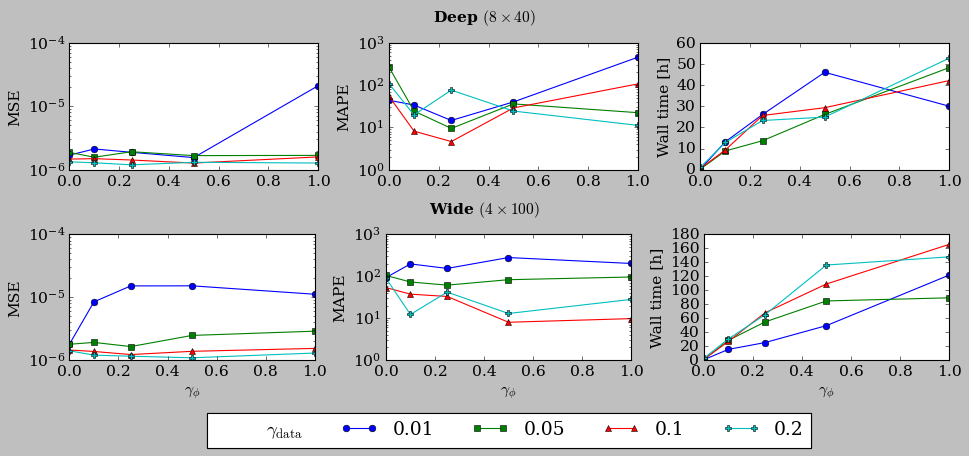

In [18]:
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


# matplotlib classic theme equivalent
# plt.style.use('classic')
# sns.set_theme(style="whitegrid", palette="bright", font_scale=1.5)

df_model1 = hl_df.where(hl_df["model"]=="MLP_8x40")
df_model2 = hl_df.where(hl_df["model"]=="MLP_4x100")
n_max = len(DM.df_train_scaled)
rows = 3
cols = 2
marker_styles = ["o", "s", "^", "P", "D", "X", "d", "p", "h", "H", "*", "x"]

model_names = ["Deep "+r"$(8\times40)$", "Wide "+r"$(4\times100)$"]

fig = plt.figure(figsize=(12, 5),constrained_layout=True)
# create 3x1 subfigs
subfigs = fig.subfigures(nrows=2, ncols=1, height_ratios=[.9, 1])
for i, (subfig, df_model) in enumerate(zip(subfigs, [df_model1, df_model2])):
    # create 1x3 subplots per subfig
    axes = subfig.subplots(nrows=1, ncols=3)
    subfig.suptitle(model_names[i], weight='bold')
    df_datas = df_model.groupby("data.data_ratio")
    #TODO Replace df_datas with df_fc10,0
    j = 0
    for name, df_data in df_datas:
        df_data.sort_values(by="data.physics.colloc_data_ratio", inplace=True)
        colloc_data_ratios = df_data["data.physics.colloc_data_ratio"]
        axes[0].plot(colloc_data_ratios, df_data["MSE"], label=f"{name}", marker = marker_styles[j])
        axes[0].set_yscale('log')
        axes[0].set_ylabel("MSE")

        axes[1].plot(colloc_data_ratios, df_data["MAPE"], label=name, marker = marker_styles[j])
        axes[1].set_yscale('log')
        axes[1].set_ylabel("MAPE")

        axes[2].plot(colloc_data_ratios, df_data["total_time[h]"], label=name, marker = marker_styles[j])
        axes[2].set_ylabel("Wall time [h]")

        if i>0:
            axes[0].set_xlabel(r"$\gamma_\phi$")
            axes[1].set_xlabel(r"$\gamma_\phi$")
            axes[2].set_xlabel(r"$\gamma_\phi$")
        j += 1

    handles, labels = axes[2].get_legend_handles_labels()
    handles = [Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)] + handles
    labels = [r"$\gamma_\mathrm{data}$"] + labels
    fig.legend(handles, labels, bbox_to_anchor=(.85,0), ncol=len(df_model["data.data_ratio"].unique())+1)

    

    # make share legend
    # plt.legend(loc='upper left', ncol=len(df_model["data.data_ratio"].unique()))
    # make share legend
    # plt.legend(loc='upper left', ncol=len(df_model["data.data_ratio"].unique()))
# plt.tight_layout()
plt.show()
# plt.savefig("model_comparison.pdf", bbox_inches='tight')

In [19]:
data_models = hl_df.where(hl_df["data.physics.colloc_data_ratio"]==0.0)
data_models = data_models[data_models["data.physics.colloc_data_ratio"].notna()]

best_data_models_MSE = data_models.where(data_models["MSE"]==data_models["MSE"].min())
best_data_models_MSE = best_data_models_MSE[best_data_models_MSE['MSE'].notna()].iloc[0]

best_data_MAPE = data_models.where(data_models["MAPE"]==data_models["MAPE"].min())
best_data_MAPE = best_data_MAPE[best_data_MAPE['MAPE'].notna()].iloc[0]

best_data_MAE = data_models.where(data_models["MAE"]==data_models["MAE"].min())
best_data_MAE = best_data_MAE[best_data_MAE['MAE'].notna()].iloc[0]


best_data_models_df = pd.concat([best_data_models_MSE, best_data_MAE, best_data_MAPE], axis=1).T.reset_index(drop=True)
best_data_models_df = best_data_models_df.reset_index()
best_data_models_df.drop(columns=["level_0", "level_1", "index", "paths", "optimizer", "time_per_epoch[m]", "finished", "R2"], inplace=True)
best_data_models_df = best_data_models_df[["model", "data.data_ratio", "data.physics.colloc_data_ratio", "MSE", "MAE", "RMSE", "MAPE", "MSE_pinn", "total_time[h]", "epochs"]]


best_data_models_df_model1 = best_data_models_df.where(best_data_models_df["model"]=="MLP_4x100")
best_data_models_df_model1 = best_data_models_df_model1[best_data_models_df_model1['model'].notna()].iloc[0:1]
best_data_models_df_model1["model"] = "Wide "+r"$(4\times100)$"

best_data_models_df_model2 = best_data_models_df.where(best_data_models_df["model"]=="MLP_8x40")
best_data_models_df_model2 = best_data_models_df_model2[best_data_models_df_model2['model'].notna()]
best_data_models_df_model2["model"] = ["Deep "+r"$(8\times40)$" for i in range(len(best_data_models_df_model2))]

best_data_models_df = pd.concat([best_data_models_df_model1, best_data_models_df_model2], axis=0)

best_data_models_df = best_data_models_df.sort_values(by="MSE", ascending=True)
data_models_hl = best_data_models_df.style.highlight_min(subset=["MSE", "MAE", "RMSE", "MAPE", "MSE_pinn"], color = 'darkgrey')
data_models_hl

,model,data.data_ratio,data.physics.colloc_data_ratio,MSE,MAE,RMSE,MAPE,MSE_pinn,total_time[h],epochs
0,Deep $(8\times40)$,0.200000,0.000000,0.000001,0.000202,0.001155,107.320297,0.096307,1.177015,608.000000
1,Wide $(4\times100)$,0.100000,0.000000,0.000001,0.000149,0.001203,53.952924,0.175181,1.111737,962.000000
2,Deep $(8\times40)$,0.010000,0.000000,0.000002,0.000254,0.001304,43.832366,0.011039,0.303217,2474.000000


In [20]:
hl_df_model1 = hl_df.where(hl_df["model"]=="MLP_8x40")
hl_df_model1 = hl_df_model1[hl_df_model1['model'].notna()]
hl_df_model1["model"] = ["Deep "+r"$(8\times40)$" for i in range(len(hl_df_model1))]

best_MSE_model1 = hl_df_model1.where(hl_df_model1["MSE"]==hl_df_model1["MSE"].min())
best_MSE_model1 = best_MSE_model1[best_MSE_model1['MSE'].notna()].iloc[0]

best_MAE_model1 = hl_df_model1.where(hl_df_model1["MAE"]==hl_df_model1["MAE"].min())
best_MAE_model1 = best_MAE_model1[best_MAE_model1['MAE'].notna()].iloc[0]

best_MAPE_model1 = hl_df_model1.where(hl_df_model1["MAPE"]==hl_df_model1["MAPE"].min())
best_MAPE_model1 = best_MAPE_model1[best_MAPE_model1['MAPE'].notna()].iloc[0]

hl_df_model2 = hl_df.where(hl_df["model"]=="MLP_4x100")
hl_df_model2 = hl_df_model2[hl_df_model2['model'].notna()]
hl_df_model2["model"] = ["Wide "+r"$(4\times100)$" for i in range(len(hl_df_model2))]

best_MSE_model2 = hl_df_model2.where(hl_df_model2["MSE"]==hl_df_model2["MSE"].min())
best_MSE_model2 = best_MSE_model2[best_MSE_model2['MSE'].notna()].iloc[0]

best_MAPE_model2 = hl_df_model2.where(hl_df_model2["MAPE"]==hl_df_model2["MAPE"].min())
best_MAPE_model2 = best_MAPE_model2[best_MAPE_model2['MAPE'].notna()].iloc[0]

best_models_df = pd.concat([best_MSE_model1, best_MAPE_model1, best_MAE_model1, best_MSE_model2, best_MAPE_model2], axis=1).T

best_models_df = best_models_df.reset_index()
best_models_df.drop(columns=["level_0", "level_1", "index", "paths", "optimizer", "time_per_epoch[m]", "finished", "R2"], inplace=True)
best_models_df = best_models_df[["model", "data.data_ratio", "data.physics.colloc_data_ratio", "MSE", "MAE", "RMSE", "MAPE", "MSE_pinn", "total_time[h]", "epochs"]]


best_models_df = best_models_df.sort_values(by="MSE", ascending=True)
best_models_df_hl = best_models_df.style.highlight_min(subset=["MSE", "MAE", "RMSE", "MAPE", "MSE_pinn"], color = 'darkgrey')
best_models_df_hl

,model,data.data_ratio,data.physics.colloc_data_ratio,MSE,MAE,RMSE,MAPE,MSE_pinn,total_time[h],epochs
3,Wide $(4\times100)$,0.200000,0.500000,0.000001,0.000133,0.001043,12.967391,0.000001,136.213267,2499.000000
0,Deep $(8\times40)$,0.200000,0.250000,0.000001,0.000188,0.001093,76.412511,0.000003,23.298405,882.000000
2,Deep $(8\times40)$,0.200000,1.000000,0.000001,0.000136,0.001130,11.230751,0.000002,52.715814,845.000000
4,Wide $(4\times100)$,0.100000,0.500000,0.000001,0.000174,0.001174,8.006853,0.000002,109.029476,2462.000000
1,Deep $(8\times40)$,0.100000,0.250000,0.000001,0.000166,0.001193,4.641388,0.000001,25.675419,1237.000000


In [21]:
best_models_combined = pd.concat([best_models_df, best_data_models_df], axis=0)
best_models_combined.sort_values(by=["model", "data.data_ratio", "data.physics.colloc_data_ratio"], inplace=True)
best_models_combined = best_models_combined.reset_index(drop=True)
best_models_combined_hl = best_models_combined.style.highlight_min(subset=["MSE", "MAE", "RMSE", "MAPE", "MSE_pinn"], color = 'darkgrey')
best_models_combined_hl

,model,data.data_ratio,data.physics.colloc_data_ratio,MSE,MAE,RMSE,MAPE,MSE_pinn,total_time[h],epochs
0,Deep $(8\times40)$,0.010000,0.000000,0.000002,0.000254,0.001304,43.832366,0.011039,0.303217,2474.000000
1,Deep $(8\times40)$,0.100000,0.250000,0.000001,0.000166,0.001193,4.641388,0.000001,25.675419,1237.000000
2,Deep $(8\times40)$,0.200000,0.000000,0.000001,0.000202,0.001155,107.320297,0.096307,1.177015,608.000000
3,Deep $(8\times40)$,0.200000,0.250000,0.000001,0.000188,0.001093,76.412511,0.000003,23.298405,882.000000
4,Deep $(8\times40)$,0.200000,1.000000,0.000001,0.000136,0.001130,11.230751,0.000002,52.715814,845.000000
5,Wide $(4\times100)$,0.100000,0.000000,0.000001,0.000149,0.001203,53.952924,0.175181,1.111737,962.000000
6,Wide $(4\times100)$,0.100000,0.500000,0.000001,0.000174,0.001174,8.006853,0.000002,109.029476,2462.000000
7,Wide $(4\times100)$,0.200000,0.500000,0.000001,0.000133,0.001043,12.967391,0.000001,136.213267,2499.000000


In [22]:
for column in best_models_combined.columns:
    if column == "epochs":
       best_models_combined[column] = best_models_combined[column].astype(int)
    elif column == "total_time[h]":
        best_models_combined[column] = best_models_combined[column].astype(float).round(3).astype(str)
    else:
        pass
        # hl_df[column] = hl_df[column].astype(float).round(5).astype(str)

best_models_combined.columns = [r'Model', r'$\gamma_\mathrm{data}$', r"$\gamma_\phi$", r"$\textrm{MSE}$", r"$\textrm{MAE}$", r"$\textrm{RMSE}$", r"$\textrm{MAPE}$", r"$\mathrm{MSE}_\phi$", 'Wall time [h]', 'epochs']

In [23]:
# Define a custom formatter for scientific notation
scientific_formatter = "{:.2e}".format
best_models_combined.to_latex("../figures/Select_Best_Exp.tex", 
                float_format="{:.2e}".format,
                escape=False)

best_models_combined.to_latex("../figures/Select_Best_Exp_formatted.tex", 
                float_format="{:.2f}".format,
                escape=False)

In [24]:
# load latex table
with open("../figures/Select_Best_Exp.tex", 'r') as f:
    lines = f.readlines()

with open("../figures/Select_Best_Exp_formatted.tex", 'r') as f:
    lines2 = f.readlines()

# Change inital lines and line indicatiors to match Journal of Physics and own style

for i, _ in enumerate(lines):
    splitted_line = lines[i].split("&")
    for j, splited in enumerate(splitted_line):
        if (r"e-" in splited or r"e+" in splited):
            power = int(splited.split(r"e")[1])
            if np.abs(power) < 3:
                splitted2 = lines2[i].split("&")
                splitted_line[j] = splitted2[j]
            else:
                splitted_line[j] = r"\num{"+splited+r"}"

    if r"\\" in lines[i]:
        lines[i] = lines[i].replace(r"\\", r"\cr")
    if "&" in lines[i]:
        lines[i] = "&".join(splitted_line[1:])

start_lines = [r"\begin{tabular}{cccccccccc}"+"\n", r"\br"+"\n"]
lines[:2] = start_lines
lines[3] = r"\mr"+"\n"
lines[-2] = r"\br"+"\n"
lines[-1] = r"\end{tabular}"+"\n"

# write as latex file
with open("../figures/Select_Best_Exp.tex", 'w') as f:
    f.writelines(lines)

In [25]:

df_best_mse = hl_df.where(hl_df["MSE"]==hl_df["MSE"].min())
df_best_mse = df_best_mse[df_best_mse['MSE'].notna()].iloc[0]

df_best_mape = hl_df.where(hl_df["MAPE"]==hl_df["MAPE"].min())
df_best_mape = df_best_mape[df_best_mape['MAPE'].notna()].iloc[0]

print(df_best_mse['paths'])
print(df_best_mape['paths'])


/home/jpsch/code/jax-flax-wake-pinn/Results/Experiment1/28/checkpoints/2384/default
/home/jpsch/code/jax-flax-wake-pinn/Results/Experiment1/19/checkpoints/1036/default


In [26]:
# hl_df = model_comparison_df.reset_index()

hl_df = hl_df.sort_values(by="MSE", ascending=True)
hl_df = hl_df.style.highlight_min(subset=["MSE", "MAE", "RMSE", "MAPE"], color = 'darkgrey')
hl_df = hl_df.highlight_max(subset=["R2"], color = 'darkgrey', axis = 0)
hl_df

,level_0,level_1,data.data_ratio,model,MSE,MAE,RMSE,MAPE,R2,MSE_pinn,paths,finished,total_time[h],epochs,time_per_epoch[m],data.physics.colloc_data_ratio,optimizer
29,28,Experiment1,0.200000,MLP_4x100,0.000001,0.000133,0.001043,12.967391,0.999995,0.000001,/home/jpsch/code/jax-flax-wake-pinn/Results/Experiment1/28/checkpoints/2384/default,True,136.213267,2499.000000,3.270427,0.500000,nan
27,26,Experiment1,0.200000,MLP_4x100,0.000001,0.000174,0.001073,42.014264,0.999995,0.000001,/home/jpsch/code/jax-flax-wake-pinn/Results/Experiment1/26/checkpoints/1670/default,False,65.066886,1871.000000,2.086592,0.250000,nan
44,12,Experiment2,nan,MLP_4x100,0.000001,0.000174,0.001073,42.014264,0.999995,0.000001,/home/jpsch/code/jax-flax-wake-pinn/Results/Experiment2/12/checkpoints/1670/default,False,64.279693,1871.000000,2.061348,0.250000,opt_exp_sophia_var_14
48,16,Experiment2,nan,MLP_4x100,0.000001,0.000151,0.001090,10.486896,0.999995,0.000005,/home/jpsch/code/jax-flax-wake-pinn/Results/Experiment2/16/checkpoints/736/default,False,85.016951,937.000000,5.443988,0.750000,opt_exp_sophia_var_16
28,27,Experiment1,0.200000,MLP_8x40,0.000001,0.000188,0.001093,76.412511,0.999995,0.000003,/home/jpsch/code/jax-flax-wake-pinn/Results/Experiment1/27/checkpoints/681/default,False,23.298405,882.000000,1.584925,0.250000,nan
45,13,Experiment2,nan,MLP_8x40,0.000001,0.000188,0.001093,76.412511,0.999995,0.000003,/home/jpsch/code/jax-flax-wake-pinn/Results/Experiment2/13/checkpoints/681/default,False,23.382250,882.000000,1.590629,0.250000,opt_exp_sophia_var_14
25,24,Experiment1,0.200000,MLP_4x100,0.000001,0.000150,0.001094,12.283351,0.999995,0.000002,/home/jpsch/code/jax-flax-wake-pinn/Results/Experiment1/24/checkpoints/1560/default,False,30.210200,1578.000000,1.148677,0.100000,nan
42,10,Experiment2,nan,MLP_4x100,0.000001,0.000150,0.001094,12.283351,0.999995,0.000002,/home/jpsch/code/jax-flax-wake-pinn/Results/Experiment2/10/checkpoints/1560/default,False,30.294739,1578.000000,1.151891,0.100000,opt_exp_sophia_var_13
18,18,Experiment1,0.100000,MLP_4x100,0.000001,0.000194,0.001106,33.075160,0.999994,0.000019,/home/jpsch/code/jax-flax-wake-pinn/Results/Experiment1/18/checkpoints/2483/default,True,67.770647,2499.000000,1.627146,0.250000,nan
46,14,Experiment2,nan,MLP_4x100,0.000001,0.000140,0.001112,31.631029,0.999994,0.000002,/home/jpsch/code/jax-flax-wake-pinn/Results/Experiment2/14/checkpoints/1173/default,False,91.286426,1374.000000,3.986307,0.500000,opt_exp_sophia_var_15


In [27]:
# from matplotlib import pyplot as plt
# for i, (plot_classes_list, tb_dfs_list, plot_classes_list) in enumerate(zip(plot_classes_list, tb_dfs_list, plot_classes_list)):
#     for j, (df, plot_class) in enumerate(zip(tb_dfs, plot_classes)):
#         if plot_class is None:
#             continue
#         title = final_model_paths[j].split("/")[-2]
#         fig, axes = plt.subplots(1, 2, figsize=(20, 6))
#         plt.title(f"Exp: {i}, Model {title}")
#         if "Loss/pinn" in df.columns:
#             df.plot("step",["Loss/tot", "loss", "Loss/pinn", "Loss/val"], logy=True, ax=axes[0])
#             df.plot("step",["Loss/alpha_data", "Loss/alpha_pinn"], logy=False, ax=axes[1])
#         else:
#             df.plot("step",["loss", "Loss/val"], logy=True, ax=axes[0])

#         plot_class.plot_pred_triplet("U_z", flowcase=0)
#         plot_class.plot_pred_triplet("U_r", flowcase=0)
#         plot_class.plot_pred_triplet("P", flowcase=0)

: 